# Overview 



This notebook is an example R script on how to prepare the input data prior to building a base GRN.
Here, we use Cicero to extract the cis-regulatory connections between scATAC-seq peaks.



### Notebook file
This notebook is available on CellOracle’s GitHub page as this jupyter notebook (with R kernel) or an R notebook. The notebooks are identical. Please use whichever one you prefer.

- Jupyter notebook with R kernel: https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/01_ATAC-seq_data_processing/option1_scATAC-seq_data_analysis_with_cicero/01_atacdata_analysis_with_cicero_and_monocle3.ipynb
- R notebook: https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/01_ATAC-seq_data_processing/option1_scATAC-seq_data_analysis_with_cicero/01_atacdata_analysis_with_cicero_and_monocle3.Rmd



### CAUTION: 

- This notebook is intended to **demonstrate data preprocessing steps prior to starting a CellOracle analysis**. CellOracle is NOT used in this notebook, and this notebook is not the CellOracle analysis.

- Here, we will use `Cicero` to process scATAC-seq data. If you are new to this packages, pelase review the Cicero's documentation to learn the basic process of Cicero in advance.  

 - `Cicero` documentation: https://cole-trapnell-lab.github.io/cicero-release/docs_m3/ 

- The R library, cicero and monocle3 is NOT the part of celloracle package. **Please install them yourself if you use this notebook**.

# 0. Import library

In [2]:
library(cicero)
library(monocle3)

# 1. Download data

This tutorial uses fetal brain scATAC-seq data from a 10x Genomics database. If you’re using your own scATAC-seq data, you will not need to download this dataset.

You can download the demo file with the following command.

**Note: If the file download fails, please manually download and unzip the data.**
http://cf.10xgenomics.com/samples/cell-atac/1.1.0/atac_v1_E18_brain_fresh_5k/atac_v1_E18_brain_fresh_5k_filtered_peak_bc_matrix.tar.gz

In [3]:
# Create folder to store data
dir.create("data")

# Download demo dataset from 10x genomics 
download.file(url = "http://cf.10xgenomics.com/samples/cell-atac/1.1.0/atac_v1_E18_brain_fresh_5k/atac_v1_E18_brain_fresh_5k_filtered_peak_bc_matrix.tar.gz",
              destfile = "data/matrix.tar.gz")
# Unzip data
system("tar -xvf data/matrix.tar.gz -C data")

In [4]:
# You can substitute the data path below to your scATAC-seq data.
data_folder <- "data/filtered_peak_bc_matrix"

# Create a folder to save results
output_folder <- "cicero_output"
dir.create(output_folder)

# 2. Load data and make Cell Data Set (CDS) object 
## 2.1. Process data to make CDS object

In [5]:
# Read in matrix data using the Matrix package
indata <- Matrix::readMM(paste0(data_folder, "/matrix.mtx")) 
# Binarize the matrix
indata@x[indata@x > 0] <- 1

# Format cell info
cellinfo <- read.table(paste0(data_folder, "/barcodes.tsv"))
row.names(cellinfo) <- cellinfo$V1
names(cellinfo) <- "cells"

# Format peak info
peakinfo <- read.table(paste0(data_folder, "/peaks.bed"))
names(peakinfo) <- c("chr", "bp1", "bp2")
peakinfo$site_name <- paste(peakinfo$chr, peakinfo$bp1, peakinfo$bp2, sep="_")
row.names(peakinfo) <- peakinfo$site_name

row.names(indata) <- row.names(peakinfo)
colnames(indata) <- row.names(cellinfo)

# Make CDS
input_cds <-  suppressWarnings(new_cell_data_set(indata,
cell_metadata = cellinfo,
gene_metadata = peakinfo))

input_cds <- monocle3::detect_genes(input_cds)

#Ensure there are no peaks included with zero reads
input_cds <- input_cds[Matrix::rowSums(exprs(input_cds)) != 0,] 

# 3. Qauality check and Filtering

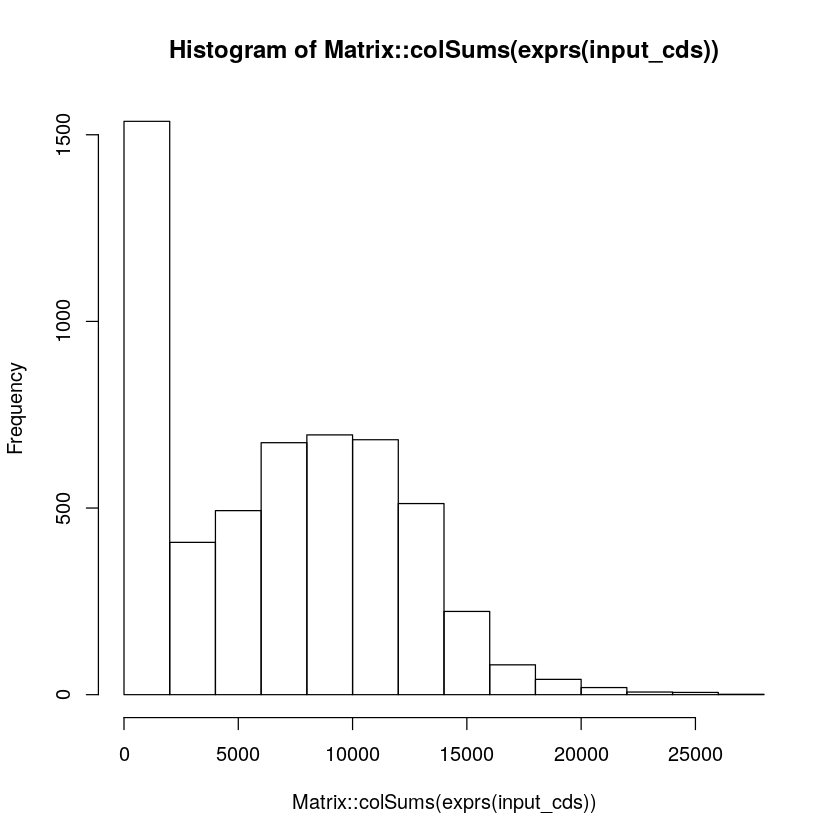

In [6]:
# Visualize peak_count_per_cell
hist(Matrix::colSums(exprs(input_cds)))

In [7]:
# Filter cells by peak_count
# Please set an appropriate threshold values according to your data 
max_count <-  15000
min_count <- 2000
input_cds <- input_cds[,Matrix::colSums(exprs(input_cds)) >= min_count] 
input_cds <- input_cds[,Matrix::colSums(exprs(input_cds)) <= max_count] 


# 4. Process Cicero-CDS object

In [8]:
# Data preprocessing
set.seed(2017)

input_cds <- detect_genes(input_cds)
input_cds <- estimate_size_factors(input_cds)
input_cds <- preprocess_cds(input_cds, method = "LSI")

# Dimensional reduction with umap
input_cds <- reduce_dimension(input_cds, reduction_method = 'UMAP', 
                              preprocess_method = "LSI")
umap_coords <- reducedDims(input_cds)$UMAP


cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = umap_coords)

# Save Cds object (Optional)
#saveRDS(cicero_cds, paste0(output_folder, "/cicero_cds.Rds"))



Overlap QC metrics:
Cells per bin: 50
Maximum shared cells bin-bin: 44
Mean shared cells bin-bin: 0.84960828849071
Median shared cells bin-bin: 0



# 5. Load reference genome information

To run Cicero, you need to get a genomic coordinate file that contains the length of each chromosome.
You can download the mm10 genomic information with the following command.

If your scATAC-seq data was generated with a different reference genome, you will need to get the genome coordinates file for the reference genome you used. See the Cicero documentation for more information.

https://cole-trapnell-lab.github.io/cicero-release/docs_m3/#installing-cicero

In [9]:
# !!Please make sure that the reference genome information below matches your scATAC-seq reference genome.

# If your scATAC-seq was aligned to the mm10 reference genome, you can read the chromosome length file using the following command.
download.file(url = "https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/mm10_chromosome_length.txt",
              destfile = "./mm10_chromosome_length.txt")
chromosome_length <- read.table("./mm10_chromosome_length.txt")

# For mm9 genome, you can use the following command.
#data("mouse.mm9.genome")
#chromosome_length <- mouse.mm9.genome

# For hg19 genome, you can use the following command.
#data("human.hg19.genome")
#chromosome_length <- mhuman.hg19.genome



# 6. Run Cicero

In [10]:
# Run the main function
conns <- run_cicero(cicero_cds, chromosome_length) # Takes a few minutes to run

# Save results (Optional)
#saveRDS(conns, paste0(output_folder, "/cicero_connections.Rds"))

# Check results
head(conns)

,Peak1,Peak2,coaccess
,<chr>,<fct>,<dbl>
1,chr10_100006139_100006389,chr10_99774288_99774570,-0.003546179
2,chr10_100006139_100006389,chr10_99825945_99826237,-0.027536333
3,chr10_100006139_100006389,chr10_99830012_99830311,0.009588013
4,chr10_100006139_100006389,chr10_99833211_99833540,-0.008067111
5,chr10_100006139_100006389,chr10_99941805_99941955,0.000000000
7,chr10_100006139_100006389,chr10_100015291_100017830,-0.015018099


# 7. Save results for the next step

In [26]:
all_peaks <- row.names(exprs(input_cds))
write.csv(x = all_peaks, file = paste0(output_folder, "/all_peaks.csv"))
write.csv(x = conns, file = paste0(output_folder, "/cicero_connections.csv"))


**Please go to next step: TSS annotation**

https://morris-lab.github.io/CellOracle.documentation/tutorials/base_grn.html#step2-tss-annotation